# Weather forecast

- Thai Meteorological Department : Weather data source  
http://www.rnd.tmd.go.th/bigdata.php
- ASOS meta-data explanation  
https://cran.r-project.org/web/packages/riem/vignettes/riem_package.html
- Weather study guide : decoding METAR weather report format  
http://meteocentre.com/doc/metar.html
- Thai Meteorological Department : QA session : What factor requride to forecast weather?   
https://www.tmd.go.th/info/info.php?FileID=84
---

    "ในโลกธุรกิจ ระบบการขนส่ง หรือ logistic มีความสำคัญเป็นอยากมากในหลายภาคส่วน และสภาพอากาศก็เป็นอีกหนึ่งปัจจัยที่อาจทำให้ workflow ในการทำงาน มีปัญหาและอาจกระทบต่อการดำเนินธุรกิจต่อไปเป็นทอดๆต่อไปได้ ดังนั้นการรู้สภาพอากาศล่วงหน้าจึงเป็นสิ่งที่สำคัญอย่างหนึ่งในการวางแผนการทำงานในธุรกิจ ในวันนี้เราจึงมานำเสนอการประยุกต์ machine learning แบบง่ายๆ ในการพยากรณ์สภาพอากาศ"

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

# Import Data

    ดึงข้อมูลจากทางเว็บของกรมอุตุมาเก็บไว้ที่ github โดยข้อมูลที่ใช้ในครั้งนี้เป็นข้อมูล METAR ตั้งแต่ปี 2011 - 2018

In [7]:
# ทำการ loop เพื่อดึงข้อมูลหลายๆไฟล์ที่เก็บไว้บน website github โดยทำการดึงข้อมูลตั้งแต่ปี 2011 - 2018 เข้ามาเก็บไว้เป็น list ข้อมูล 

year = [2011,2012,2013,2014,2015,2016,2017,2018]
data = []

for i in year :
    weather = pd.read_csv(f'https://raw.githubusercontent.com/korpong-si/propk/master/TH_weather/decode_{i}.txt',
                          sep=',', 
                          low_memory=False,
                          parse_dates = ['valid'])
    
    weather = weather[weather.station == 'VTBU']
    data.append(weather)

In [8]:
# นำ list ข้อมูลที่ได้มาเชื่อมกันเป็นตารางเดียวโดยมีการกำหนดชื่อ column ขึ้นมาใหม่

weather = pd.concat(data, ignore_index=True,sort = False)
col = ['station', 'valid', 'tmpc', 'dwpc', 'relh', 'drct', 'sknt',
       'alti', 'mslp','p01m', 'vsby', 'gust', 'gust_mph', 'skyc1',
       'skyc2', 'skyc3', 'skyl1', 'skyl2', 'skyl3', 'presentwx', 'sped']

weather.columns = col

In [9]:
weather.sample(5)

,station,valid,tmpc,dwpc,relh,drct,sknt,alti,mslp,p01m,...,gust,gust_mph,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,presentwx,sped
48830,VTBU,2014-07-13 18:00:00,28.00,23.00,74.28,290.00,6.00,29.74,M,0.0,...,M,NaN,FEW,SCT,BKN,2000.00,12000.00,30000.00,M,NaN
71450,VTBU,2015-12-29 00:00:00,22.00,19.00,83.09,20.00,5.00,30.02,M,0.0,...,M,NaN,FEW,M,M,2000.00,M,M,BR,NaN
67354,VTBU,2015-10-02 03:30:00,31.00,23.00,62.47,320.00,4.00,29.91,M,0.0,...,M,NaN,FEW,BKN,M,2000.00,30000.00,M,M,NaN
46354,VTBU,2014-05-19 22:00:00,28.00,25.00,83.77,0.00,0.00,29.80,M,0.0,...,M,NaN,FEW,BKN,M,2000.00,30000.00,M,M,NaN
2152,VTBU,2011-10-05 13:30:00,25.00,24.00,94.19,290.00,4.00,29.83,M,M,...,M,M,FEW,SCT,BKN,2000.00,12000.00,30000.00,M,NaN


## Descriptive Analytics

Data avaliable                                                                                 | required for prediction methods                
--------------------------------------------------------------------------------------------------|-----------------------------------------------------
 1  station : three or four character site identifier                                             |                                                             
 2  valid   : timestamp of the observation (UTC)                                                  |                                                           
 3  tmpc    : Air Temperature in celsius, typically @ 2 meters                                    | 2. อุณหภูมิของอากาศ ดินในความลึกระดับต่าง ๆ และน้ำ (celsius) 
 4  dwpc    : Dew Point Temperature in celsius, typically @ 2 meters                              |                                                         
 5  relh    : Relative Humidity in %                                                              | 5. ความชื้นสัมพัทธ์ของอากาศ มีหน่วยเป็น " เปอร์เซ็นต์ "         
 6  drct    : Wind Direction in degrees from north                                                | 4. ทิศทางลม มีหน่วยเป็น " องศา " (degrees)               
 7  sknt    : Wind Speed in knots                                                                 | 3. ความเร็วลมผิวพื้นและชั้นบน มีหน่วยเป็น " น็อต " (knots)     
 8  alti    : Pressure altimeter in inches                                                        | 1. ความกดของบรรยากาศมีหน่วยเป็น " นิ้ว " (inch)   
 9  mslp    : Sea Level Pressure in millibar                                                      | 
 10 p01m    : One hour precipitation for the period from the observation time in millimeters.     | 6. หยาดน้ำฟ้า มีหน่วยเป็น " มิลลิเมตร " (millimeters)            
 11 vsby    : Visibility in km                                                                    | 10. ทัศนวิสัย มีหน่วยเป็น " เมตร หรือ กิโลเมตร "              
 12 gust    : Wind Gust in knots                                                                  | 3. ความเร็วลมผิวพื้นและชั้นบน มีหน่วยเป็น " น็อต " (knots)             
 13 skyc1   : Sky Level 1 Coverage                                                                |                                                       
 14 skyc2   : Sky Level 2 Coverage                                                                |                                                            
 15 skyc3   : Sky Level 3 Coverage                                                                |                                                            
 16 skyl1   : Sky Level 1 Altitude in feet                                                        | 11. ความสูงของฐานเมฆ มีหน่วยเป็น " เมตร หรือ ฟุต "             
 17 skyl2   : Sky Level 2 Altitude in feet                                                        |                                                        
 18 skyl3   : Sky Level 3 Altitude in feet                                                        |                                                      
 19 presentwx: Present Weather Codes                                                              |  
                                                                                                  | 7. การระเหยของน้ำ มีหน่วยเป็น " มิลลิเมตร " (millimeters)   
                                                                                                  | 8. ปริมาณรังสี มีหน่วยเป็น " mw "                               
                                                                                                  | 9. ความยาวนานของแสงแดด มีหน่วยเป็น " ชั่วโมง "              
        


    "จากตารางข้างต้นจะเห็นได้ว่า จำนวนตัวแปรในข้อมูลที่เราทำการดึงจากกรมอุตุนิยมวิทยากับข้อมูลตัวแปรที่ทางกรมอุตุนิยมวิทยาใช้ในการพยากรณ์จริงๆมีข้อมูลที่แตกต่างกัน"

# Data Preparation

In [10]:
# ดูค่า unique ของแต่ละ column เพื่อดูรูปแบบของข้อมูล

for i in weather.columns:
    print(f'[{i} : {weather[i].unique()}]')
    print ('-' * 80)

[station : ['VTBU']]
--------------------------------------------------------------------------------
[valid : ['2011-07-02T05:00:00.000000000' '2011-07-02T05:30:00.000000000'
 '2011-07-02T06:00:00.000000000' ... '2018-03-27T22:30:00.000000000'
 '2018-03-27T23:00:00.000000000' '2018-03-27T23:30:00.000000000']]
--------------------------------------------------------------------------------
[tmpc : ['29.00' '30.00' '28.00' '25.00' '24.00' '26.00' '27.00' 'M' '31.00'
 '32.00' '34.00' '33.00' '19.00' '23.00' '22.00' '20.00' '35.00' '21.00'
 '17.00' '11.00' '36.00' '3.00' '37.00' '38.00' '39.00' '2.00' '12.00'
 '18.00' '16.00' '15.00' '14.00' '13.00' '10.00' '7.00']]
--------------------------------------------------------------------------------
[dwpc : ['25.00' '26.00' '24.00' '23.00' 'M' '35.00' '20.00' '4.00' '27.00'
 '22.00' '21.00' '19.00' '18.00' '17.00' '14.00' '10.00' '29.00' '16.00'
 '15.00' '13.00' '11.00' '2.00' '6.00' '28.00' '34.00' '12.00' '8.00'
 '9.00' '7.00' '5.00' '225.0

    "หลังจากที่ทำการดึงค่าตัวแปรเพื่อออกมาดูถึงความผิดปกติของข้อมูลแล้วนั้น     จะเห็นได้ว่าในบางตัวแปรที่ได้มานั้น มีข้อมูลบางตัวที่ขึ้นเป็น M ซึ่งในที่นี้จะหมายถึงการที่ไม่มีตัวแปรนั้นอยู่ในข้อมูล ดังนั้นจึงจำเป็นต้องจัดการกับข้อมูลก่อนที่เราจะนำมาทำโมเดล" 


## จัดการกับข้อมูล Continuous

In [11]:
#แทนค่า M ในตารางข้อมูลด้วยค่า NaN

weather = weather.replace( 'M', np.nan)

In [12]:
# เปลี่ยนข้อมูลให้อยู่ในรูปแบบ float ทั้งหมดเพื่อให้นำมาคำนวณหาค่า mean ได้

col = ['tmpc', 'dwpc', 'relh', 'drct', 'sknt', 'alti', 'mslp', 'p01m',
       'vsby', 'gust', 'gust_mph', 'skyl1', 'skyl2', 'skyl3', 'sped']
for i in col:
    weather[i] = weather[i].astype('float')

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109942 entries, 0 to 109941
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   station    109942 non-null  object        
 1   valid      109942 non-null  datetime64[ns]
 2   tmpc       108230 non-null  float64       
 3   dwpc       108220 non-null  float64       
 4   relh       108210 non-null  float64       
 5   drct       108999 non-null  float64       
 6   sknt       108272 non-null  float64       
 7   alti       108235 non-null  float64       
 8   mslp       0 non-null       float64       
 9   p01m       100931 non-null  float64       
 10  vsby       108259 non-null  float64       
 11  gust       36 non-null      float64       
 12  gust_mph   7 non-null       float64       
 13  skyc1      109852 non-null  object        
 14  skyc2      78140 non-null   object        
 15  skyc3      32426 non-null   object        
 16  skyl1      100427 no

In [14]:
# ลบ error value column และ columns ที่มีจำนวนข้อมูลน้อย

weather = weather.drop(columns = ['station','mslp','gust','gust_mph','sped'])

In [15]:
# นำข้อมูลทั้ง column มาหาค่า mean เพื่อนำไปแทนค่าในข้อมูลที่เป็นค่า NaN

col = ['tmpc', 'dwpc', 'relh', 'drct', 'sknt', 'alti', 'p01m', 'vsby', 'skyl1', 'skyl2', 'skyl3']
for i in col:
    weather[i] = weather[i].fillna((weather[i].mean(numeric_only=False)))

In [16]:
weather

,valid,tmpc,dwpc,relh,drct,sknt,alti,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,presentwx
0,2011-07-02 05:00:00,29.0,25.0,79.04,190.0,4.0,29.80,0.0,6.21,FEW,SCT,BKN,2000.0,4000.00000,12000.00000,NaN
1,2011-07-02 05:30:00,29.0,25.0,79.04,180.0,4.0,29.80,0.0,6.21,FEW,SCT,BKN,2000.0,4000.00000,12000.00000,NaN
2,2011-07-02 06:00:00,29.0,25.0,79.04,200.0,6.0,29.79,0.0,6.21,FEW,SCT,BKN,2000.0,4000.00000,12000.00000,NaN
3,2011-07-02 06:30:00,30.0,26.0,79.18,190.0,6.0,29.78,0.0,6.21,FEW,BKN,BKN,2000.0,12000.00000,30000.00000,NaN
4,2011-07-02 07:00:00,30.0,26.0,79.18,200.0,6.0,29.78,0.0,6.21,FEW,BKN,BKN,2000.0,12000.00000,30000.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109937,2018-03-27 21:30:00,25.0,23.0,88.67,20.0,4.0,29.80,0.0,1.86,FEW,NaN,NaN,2000.0,20075.15458,22584.00832,BR
109938,2018-03-27 22:00:00,26.0,23.0,83.55,110.0,2.0,29.80,0.0,1.86,FEW,NaN,NaN,2000.0,20075.15458,22584.00832,BR
109939,2018-03-27 22:30:00,26.0,23.0,83.55,180.0,2.0,29.83,0.0,1.86,FEW,NaN,NaN,2000.0,20075.15458,22584.00832,BR
109940,2018-03-27 23:00:00,25.0,23.0,88.67,330.0,4.0,29.83,0.0,1.86,FEW,NaN,NaN,2000.0,20075.15458,22584.00832,BR


## จัดการข้อมูล date time

In [17]:
#นำข้อมูลวันเวลามาแยกออกเป็นวัน เดือน ปีและชั่วโมง

weather['month'] = weather['valid'].dt.month
weather['hour']  = weather['valid'].dt.strftime("%H:%M:%S")
weather['day']   = weather['valid'].dt.day
weather['year']   = weather['valid'].dt.year
weather.drop(columns = ['valid'],inplace = True)

In [18]:
# เรียง column ใน dataframe ใหม่

weather = weather[['day', 'month', 'year', 'hour', 'tmpc', 'dwpc',
                   'relh', 'drct', 'sknt', 'alti', 'p01m', 'vsby', 
                   'skyc1', 'skyc2', 'skyc3', 'skyl1', 'skyl2', 'skyl3', 'presentwx']]

## จัดการกับข้อมูลที่เป็น discrete

In [19]:
# แทนค่า missing value ด้วยค่าที่มากที่สุดในตัวแปรนั้น

weather['skyc1'] = weather['skyc1'].fillna(weather['skyc1'].value_counts().index[0])
weather['skyc1'] = weather['skyc1'].str.replace('   ',weather['skyc1'].value_counts().index[0])

In [20]:
weather['skyc2'] = weather['skyc2'].fillna(weather['skyc2'].value_counts().index[0])
weather['skyc2'] = weather['skyc2'].str.replace('   ',weather['skyc2'].value_counts().index[0])

In [21]:
weather['skyc3'] = weather['skyc3'].fillna(weather['skyc3'].value_counts().index[0])
weather['skyc3'] = weather['skyc3'].str.replace('   ',weather['skyc3'].value_counts().index[0])

## จัดการกับข้อมูล target class

In [22]:
# ลบบาง row ที่ไม่มี target class ออก

del_target = weather[weather['presentwx'].isna()]
weather.drop(del_target.index,inplace=True)

In [23]:
weather

,day,month,year,hour,tmpc,dwpc,relh,drct,sknt,alti,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,presentwx
11,2,7,2011,15:00:00,25.0,24.0,94.19,320.0,8.0,29.81,0.0,4.35,FEW,SCT,BKN,1800.0,4000.00000,12000.00000,-SHRA
12,2,7,2011,18:00:00,24.0,23.0,94.14,20.0,3.0,29.81,0.0,3.73,FEW,SCT,BKN,1800.0,3500.00000,11000.00000,-RA
13,2,7,2011,20:00:00,25.0,24.0,94.19,0.0,0.0,29.79,0.0,3.73,FEW,SCT,BKN,1800.0,3500.00000,11000.00000,-RA
8637,10,1,2012,19:30:00,26.0,19.0,65.33,10.0,3.0,29.89,0.0,3.11,FEW,BKN,BKN,2500.0,12000.00000,22584.00832,BR
9117,21,1,2012,01:00:00,26.0,24.0,88.75,0.0,0.0,29.83,0.0,4.35,FEW,SCT,BKN,1800.0,30000.00000,22584.00832,VCSH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109937,27,3,2018,21:30:00,25.0,23.0,88.67,20.0,4.0,29.80,0.0,1.86,FEW,SCT,BKN,2000.0,20075.15458,22584.00832,BR
109938,27,3,2018,22:00:00,26.0,23.0,83.55,110.0,2.0,29.80,0.0,1.86,FEW,SCT,BKN,2000.0,20075.15458,22584.00832,BR
109939,27,3,2018,22:30:00,26.0,23.0,83.55,180.0,2.0,29.83,0.0,1.86,FEW,SCT,BKN,2000.0,20075.15458,22584.00832,BR
109940,27,3,2018,23:00:00,25.0,23.0,88.67,330.0,4.0,29.83,0.0,1.86,FEW,SCT,BKN,2000.0,20075.15458,22584.00832,BR


In [24]:
weather.presentwx.unique()

array(['-SHRA', '-RA', 'BR', 'VCSH', 'VCSH/BR', 'VCSH BR', '-RABR', 'SH',
       'TS/BR', 'HZ', '-RA BR', '-SHRA BR', 'TS BR', '-TSRA BR', '-TSRA',
       'TS', 'TSRA', 'TSRA BR', 'SHRA/BR', 'VCTS', 'BR TS', 'BR VCSH',
       'BR -SHRA', 'BR -RA', 'SHRA', 'VCSH HZ', 'VCTS SH', 'RA', '+TSRA',
       '- RA', 'TS VCSH HZ', 'TS HZ', 'FG', '+TSRA BR', 'SHRA BR',
       'SH BR', 'TS SH BR', 'SH/BR', 'TS SH', '+RA', 'TS VCSH', 'VCTS BR',
       'RA BR', 'SH HZ', '-TSRA HZ', 'BR SH', '+SHRA', 'MIFG', '+SHRA BR',
       'VCTS VCSH', 'HZ SH', 'TS SH HZ', 'MIFG BR', '- RA BR', '+RA BR'],
      dtype=object)

In [25]:
# นำตัวอักษรที่เป็นค่า prefix ออกเพื่อให้เหลือแต่ค่าพยากรณ์
 
clean_target = ['-','+','\s','MI','PR','BL','BC','DR','FZ','VC','/']
for i in clean_target :
    weather['presentwx'] = weather['presentwx'].str.replace(i,'')

In [26]:
weather['presentwx'].value_counts()

BR        23252
HZ         7090
RA         1492
TS         1228
RABR        908
SH          887
TSRA        697
TSRABR      499
SHRA        385
TSBR        301
SHRABR      151
SHBR        125
TSSH         98
FG           45
SHHZ         26
BRRA         19
TSSHBR       15
TSHZ         14
BRSH         11
FGBR          3
TSRAHZ        3
BRTS          3
TSSHHZ        2
HZSH          1
BRSHRA        1
Name: presentwx, dtype: int64

In [27]:
# กระจายค่า target class ของข้อมูลที่มีมากกว่า 1 target class

weather['1']=weather['presentwx'].str[0:2]
weather['2']=weather['presentwx'].str[2:4]
weather['3']=weather['presentwx'].str[4:6]
weather['4']=weather['presentwx'].str[6:8]
weather

,day,month,year,hour,tmpc,dwpc,relh,drct,sknt,alti,...,skyc2,skyc3,skyl1,skyl2,skyl3,presentwx,1,2,3,4
11,2,7,2011,15:00:00,25.0,24.0,94.19,320.0,8.0,29.81,...,SCT,BKN,1800.0,4000.00000,12000.00000,SHRA,SH,RA,,
12,2,7,2011,18:00:00,24.0,23.0,94.14,20.0,3.0,29.81,...,SCT,BKN,1800.0,3500.00000,11000.00000,RA,RA,,,
13,2,7,2011,20:00:00,25.0,24.0,94.19,0.0,0.0,29.79,...,SCT,BKN,1800.0,3500.00000,11000.00000,RA,RA,,,
8637,10,1,2012,19:30:00,26.0,19.0,65.33,10.0,3.0,29.89,...,BKN,BKN,2500.0,12000.00000,22584.00832,BR,BR,,,
9117,21,1,2012,01:00:00,26.0,24.0,88.75,0.0,0.0,29.83,...,SCT,BKN,1800.0,30000.00000,22584.00832,SH,SH,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109937,27,3,2018,21:30:00,25.0,23.0,88.67,20.0,4.0,29.80,...,SCT,BKN,2000.0,20075.15458,22584.00832,BR,BR,,,
109938,27,3,2018,22:00:00,26.0,23.0,83.55,110.0,2.0,29.80,...,SCT,BKN,2000.0,20075.15458,22584.00832,BR,BR,,,
109939,27,3,2018,22:30:00,26.0,23.0,83.55,180.0,2.0,29.83,...,SCT,BKN,2000.0,20075.15458,22584.00832,BR,BR,,,
109940,27,3,2018,23:00:00,25.0,23.0,88.67,330.0,4.0,29.83,...,SCT,BKN,2000.0,20075.15458,22584.00832,BR,BR,,,


In [28]:
# แปลงข้อมูลที่มีค่าพยากรณ์มากกว่า 2 ให้กลายเป็นข้อมูลที่มีเพียง 1 ค่า

df = pd.melt(weather,
             id_vars=['day','month','year','hour','tmpc', 'dwpc', 'relh', 'drct', 'sknt', 'alti', 'p01m', 'vsby', 'skyc1','skyc2', 'skyc3', 'skyl1', 'skyl2', 'skyl3', 'presentwx'],
             var_name = 'x', 
             value_name='target')
df.drop(columns = 'x' , inplace=True)
df = df.replace( '', np.nan)
df.dropna(inplace=True)
df.drop(columns = 'presentwx' , inplace=True)
df

,day,month,year,hour,tmpc,dwpc,relh,drct,sknt,alti,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,target
0,2,7,2011,15:00:00,25.0,24.0,94.19,320.0,8.0,29.81,0.0,4.35,FEW,SCT,BKN,1800.0,4000.0,12000.00000,SH
1,2,7,2011,18:00:00,24.0,23.0,94.14,20.0,3.0,29.81,0.0,3.73,FEW,SCT,BKN,1800.0,3500.0,11000.00000,RA
2,2,7,2011,20:00:00,25.0,24.0,94.19,0.0,0.0,29.79,0.0,3.73,FEW,SCT,BKN,1800.0,3500.0,11000.00000,RA
3,10,1,2012,19:30:00,26.0,19.0,65.33,10.0,3.0,29.89,0.0,3.11,FEW,BKN,BKN,2500.0,12000.0,22584.00832,BR
4,21,1,2012,01:00:00,26.0,24.0,88.75,0.0,0.0,29.83,0.0,4.35,FEW,SCT,BKN,1800.0,30000.0,22584.00832,SH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111509,22,3,2018,06:30:00,26.0,22.0,78.62,340.0,6.0,29.77,0.0,1.24,FEW,SCT,BKN,1800.0,3500.0,10000.00000,BR
111510,22,3,2018,07:00:00,24.0,21.0,83.32,50.0,8.0,29.77,0.0,1.24,FEW,SCT,BKN,1800.0,3500.0,10000.00000,BR
111550,23,3,2018,03:00:00,27.0,22.0,74.11,60.0,4.0,29.85,0.0,1.86,FEW,SCT,BKN,1800.0,3500.0,22584.00832,BR
111583,23,3,2018,19:30:00,24.0,21.0,83.32,350.0,6.0,29.85,0.0,1.86,FEW,SCT,BKN,1800.0,10000.0,22584.00832,BR


Text(0.5, 1.0, 'target')

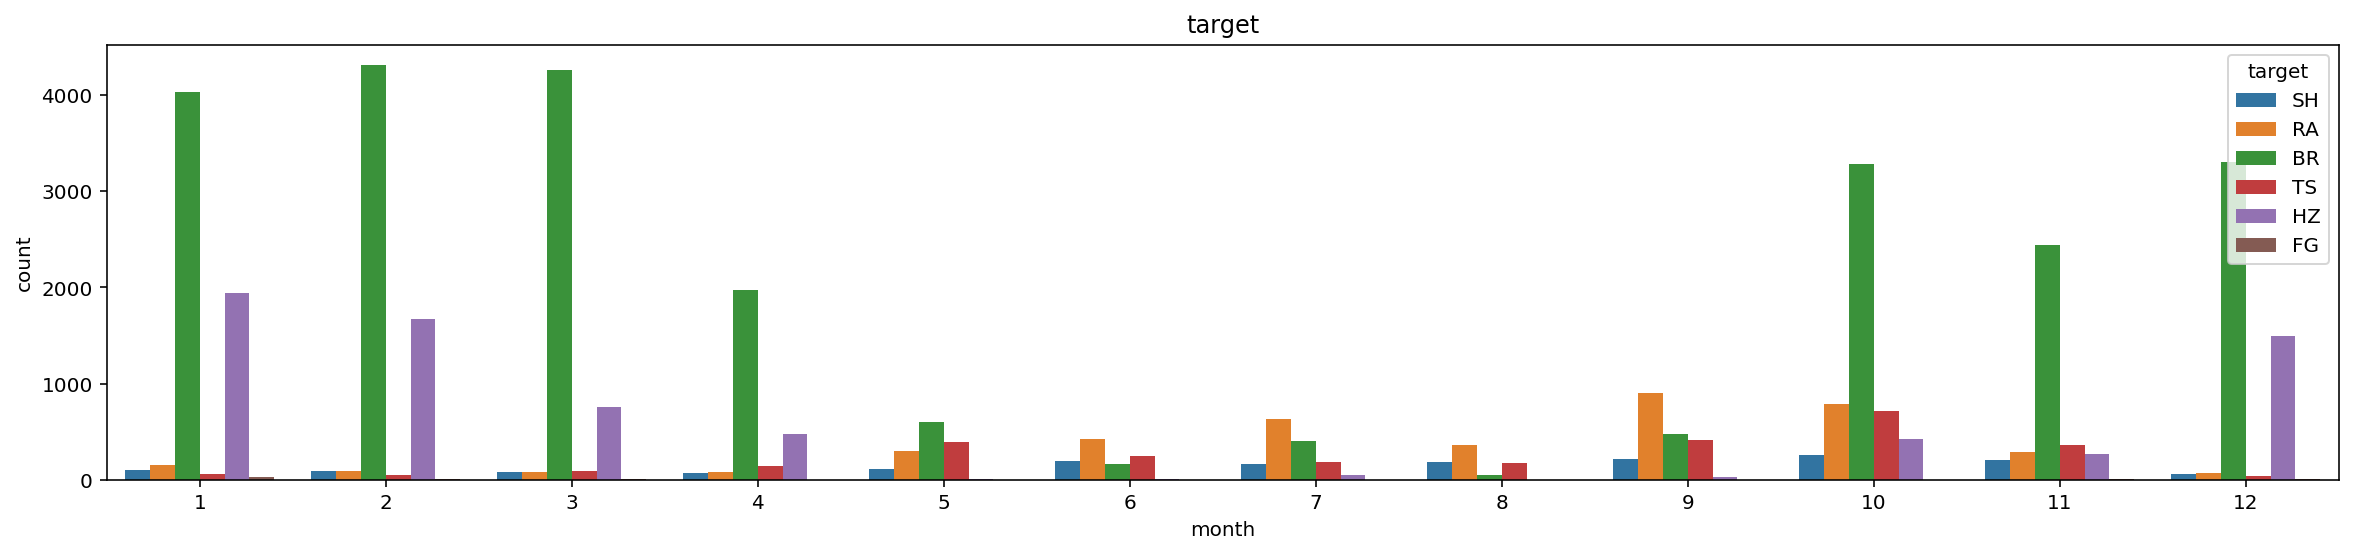

In [29]:
plt.figure(figsize=(20,4))
sns.countplot(x=df.month, hue="target", data=df).set_title('target')

    "จากกราฟแสดงค่า target class ในเดือนต่างๆ ซึ่งค่า BR หมายถึงวันที่มีหมอกหรือในที่นี้จะหมายถึงวันที่มีอากาศสดใส ส่วนค่า SH RA และ TS มีค่าหมายถึงฝนตก ซึ่งเป็นระดับที่ต่างกันออกไปโดย SH หมายถึงฝนที่ตกปอยๆ ส่วย TS หมายถึงฝนที่ตกหนักหรือพายุ ซึ่งจะเห็นได้ว่าในช่วงเดือน 5 ไปจนถึง 10 จะมีค่า 3 ค่านี้สูงโดดขึ้นมากว่าเดือนอื่นๆเป็นเพราะว่าช่วงเดือนเหลานี้ช่วงหน้าฝนของไทย และอีกหนึ่งตัวแปรที่น่าสนใจก็คือ ค่า HZ หรือแท่งสีน้ำตาลในกราฟนะคะ ค่านี้จะหมายถึงค่าฝุ่นควัน ซึ่งตรงตามกับค่าฝุ่น PM 2.5 ที่ะมีค่ามากในช่วงต้นปีและปลายปี"

## เช็คความสัมพันธ์ของข้อมูล

In [30]:
df_corr = df.copy()

In [31]:
# แปลงข้อมูล target ที่เป็น discrete ให้เป็น continuous

from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df_corr['target']  = labelencoder_X.fit_transform(df_corr['target'])
df_corr['skyc1']   = labelencoder_X.fit_transform(df_corr['skyc1']) 
df_corr['skyc2']   = labelencoder_X.fit_transform(df_corr['skyc2']) 
df_corr['skyc3']   = labelencoder_X.fit_transform(df_corr['skyc3']) 

In [32]:
dcorr = df_corr.corr()
dcorr[dcorr.index == 'target']

,day,month,year,tmpc,dwpc,relh,drct,sknt,alti,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,target
target,-0.00479,0.153757,-0.022834,0.202022,0.025639,0.002224,0.079182,0.135509,-0.049372,NaN,0.471883,-0.008783,0.07775,0.061566,-0.108663,-0.376711,-0.247061,1.0


    "การเลือกใช้ตัวแปรหรือ feature โดยในขั้นตอนนี้จะดูค่า correlation ของ target class กับตัวแปรต่างๆเป็นหลักในการดูค่าความสัมพันธ์ของข้อมูล
    โดยจะเลือกตัวแปรที่นำมาเทรนในโมเดลนี้เพียงตัวแปรที่มีค่าความสัมพันธ์กับ target class ของเราในเชิงบวกเท่านั้น ซึ่งวิธีนี้จะให้เราลดระยะเวลาในการ run model และเพิ่ม accuracy ของโมเดลเราได้ด้วย"

In [33]:
#drop feature ที่ correlation ติดลบ
#drop feature year ในภายหลัง เนื่องจากต้องการนำไปเป็นตัวแปรในการทำ visualize
feature1 = ['day','alti','p01m','skyc1','skyl1','skyl2','skyl3']

df1 = df.drop(columns = feature1)

In [34]:
df1

,month,year,hour,tmpc,dwpc,relh,drct,sknt,vsby,skyc2,skyc3,target
0,7,2011,15:00:00,25.0,24.0,94.19,320.0,8.0,4.35,SCT,BKN,SH
1,7,2011,18:00:00,24.0,23.0,94.14,20.0,3.0,3.73,SCT,BKN,RA
2,7,2011,20:00:00,25.0,24.0,94.19,0.0,0.0,3.73,SCT,BKN,RA
3,1,2012,19:30:00,26.0,19.0,65.33,10.0,3.0,3.11,BKN,BKN,BR
4,1,2012,01:00:00,26.0,24.0,88.75,0.0,0.0,4.35,SCT,BKN,SH
...,...,...,...,...,...,...,...,...,...,...,...,...
111509,3,2018,06:30:00,26.0,22.0,78.62,340.0,6.0,1.24,SCT,BKN,BR
111510,3,2018,07:00:00,24.0,21.0,83.32,50.0,8.0,1.24,SCT,BKN,BR
111550,3,2018,03:00:00,27.0,22.0,74.11,60.0,4.0,1.86,SCT,BKN,BR
111583,3,2018,19:30:00,24.0,21.0,83.32,350.0,6.0,1.86,SCT,BKN,BR


## จัดการกับข้อมูลที่เป็น outliner

    "ตัด outlier ด้วยวิธีการ IQR หรือ ค่าพิสัยระหว่างควอไทล์ ซึ่งเป็นวัดการกระจายของข้อมูลด้วยผลต่างระหว่างควอไทล์ที่ 3 และควอไทล์ที่1"

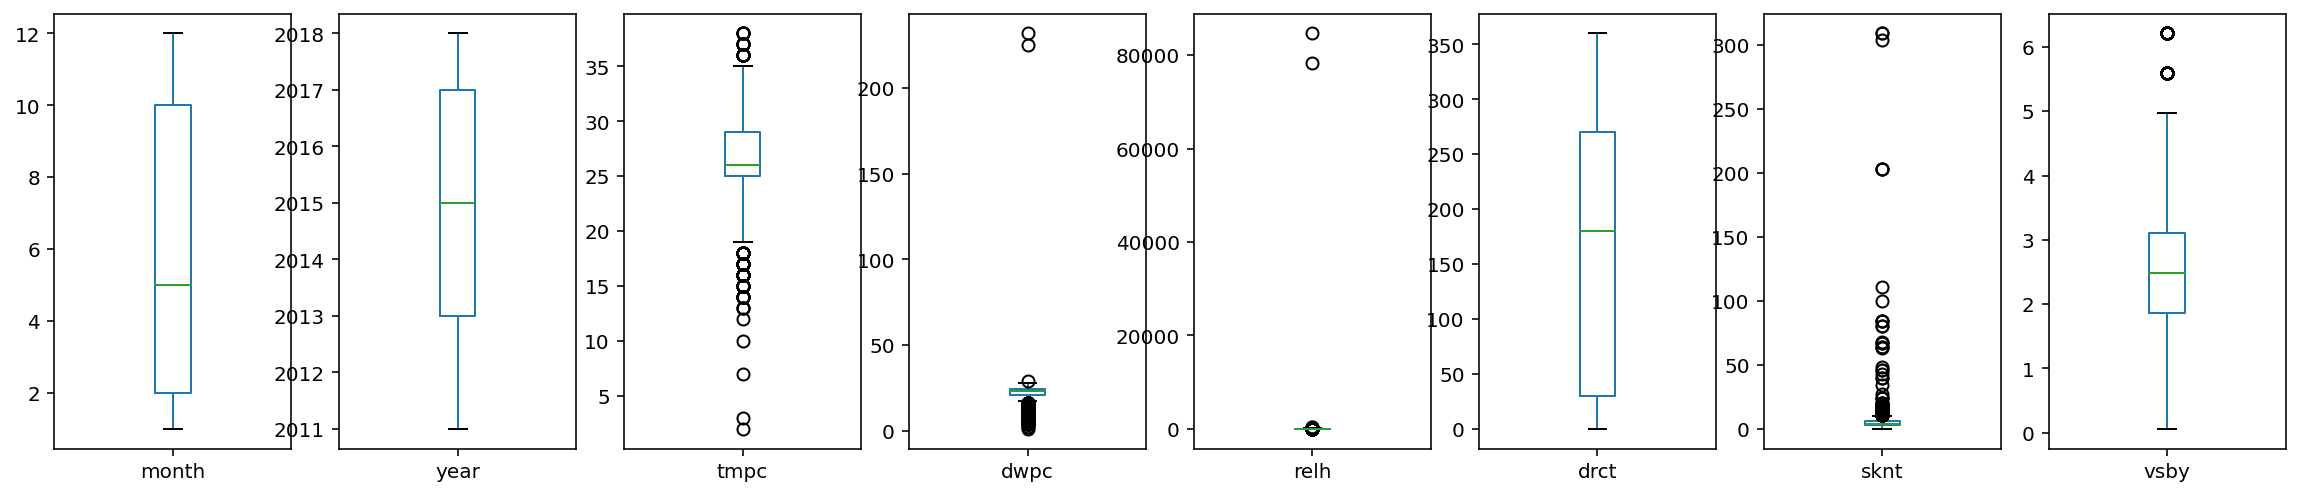

In [35]:
df1.plot(kind = 'box',subplots = True, figsize = (20,4));

In [36]:
def del_outliner(column_name):
    checkloop = 1
    count = 0
    global df1

    while checkloop == 1:
        count += 1
        # Calculate interquartile range (IQR = Q3-Q1)
        Q1 = df1[column_name].quantile(0.25)
        Q3 = df1[column_name].quantile(0.75)
        IQR = Q3 - Q1
        # Calculate Top & Bottom Border
        top_border = Q3 + (1.5 * IQR)
        bottom_border = Q1 - (1.5 * IQR)

        # The value each variable must more than 0 but bottom_border is minus value
        if bottom_border <= 0:
            bottom_border = 0

        # Find dataframe of outliers
        outliers = df1.query('{} <= {} | {} >= {} '.format(column_name,bottom_border,column_name,top_border)).copy()
        # Find dataframe of excluding outliers
        df1 = df1.query('{} > {} & {} < {} '.format(column_name,bottom_border,column_name,top_border)).copy()
        # If this loop have outliers, it will be redo again until no outliers
        if outliers[column_name].count() == 0:
            checkloop = 0
    return df1

In [37]:
outliner_col = ['tmpc', 'dwpc','relh','sknt','vsby']

for i in outliner_col:
    del_outliner(i)
    

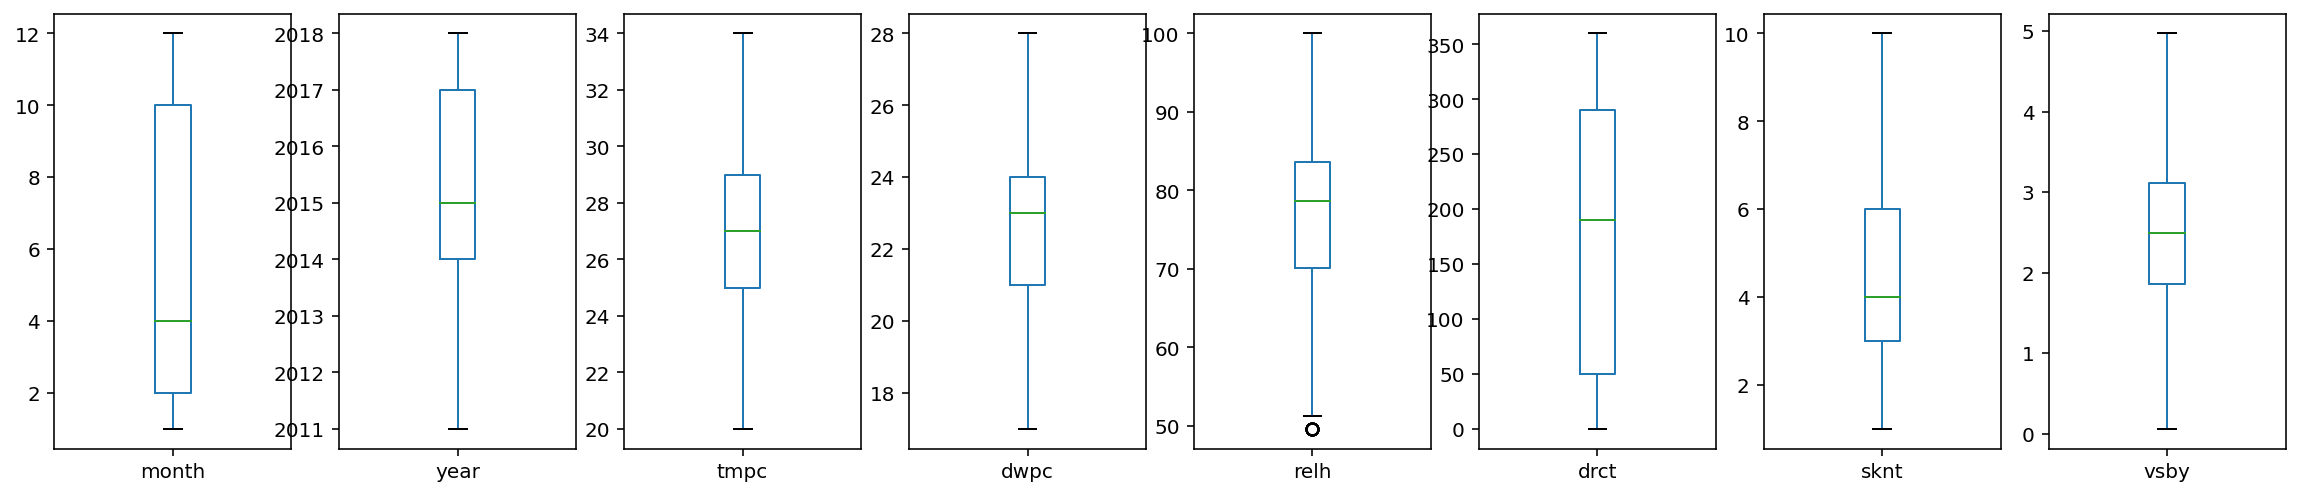

In [38]:
df1.plot(kind = 'box',subplots = True, figsize = (20,4));

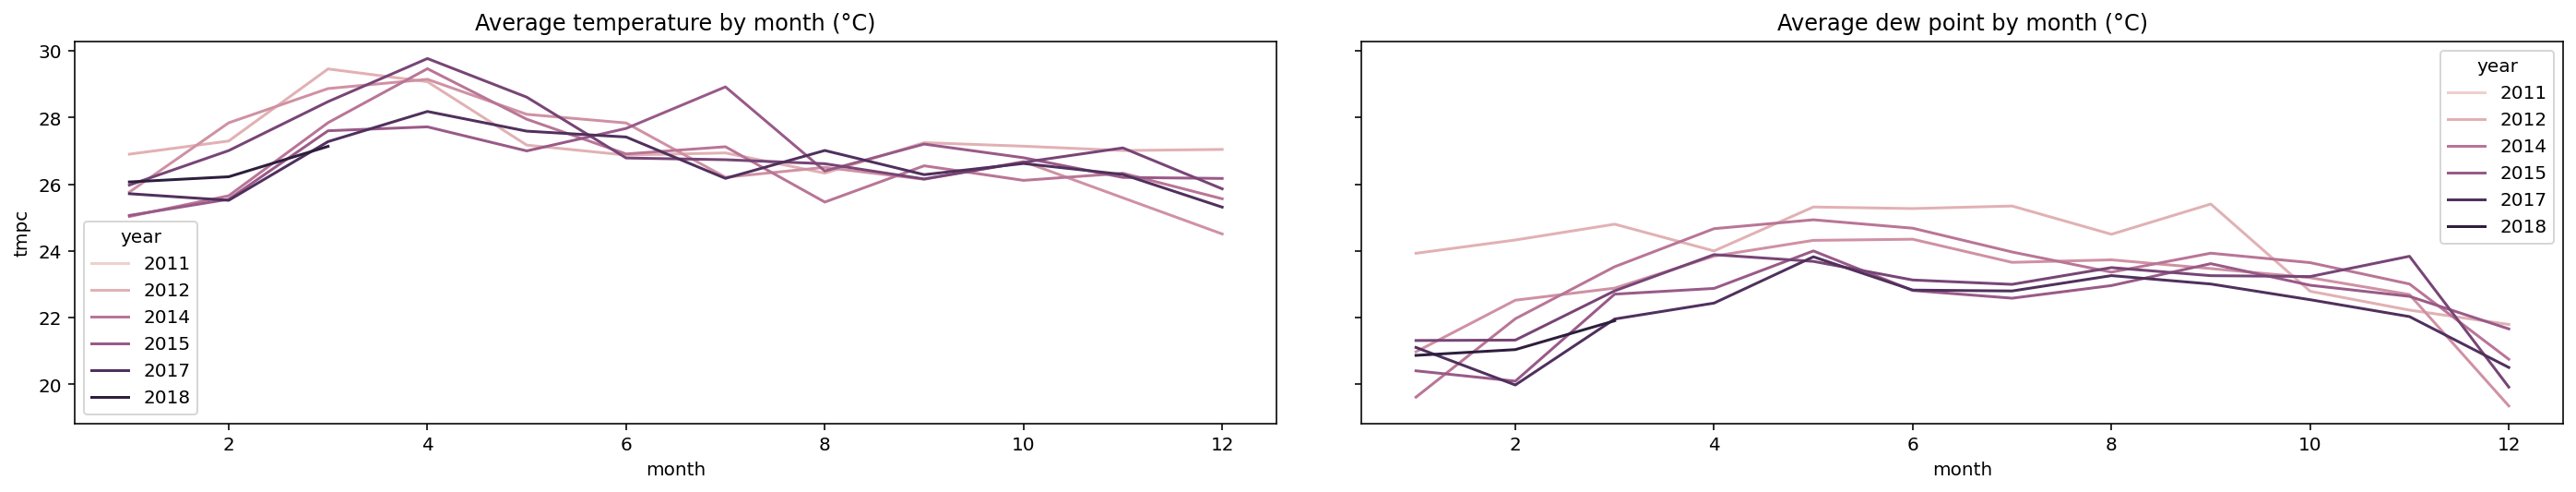

In [39]:
fig, ax = plt.subplots(1,2 , sharex=False, sharey=True, figsize=(20, 4))
fig. tight_layout(pad=3.0)

sns.lineplot(x='month',y='tmpc',hue="year",ax=ax[0] ,data=df1.groupby(['month','year']).mean().reset_index()).set_title('Average temperature by month (°C)') 
sns.lineplot(x='month',y='dwpc',hue="year",ax=ax[1] ,data=df1.groupby(['month','year']).mean().reset_index()).set_title('Average dew point by month (°C)')  

plt.show()

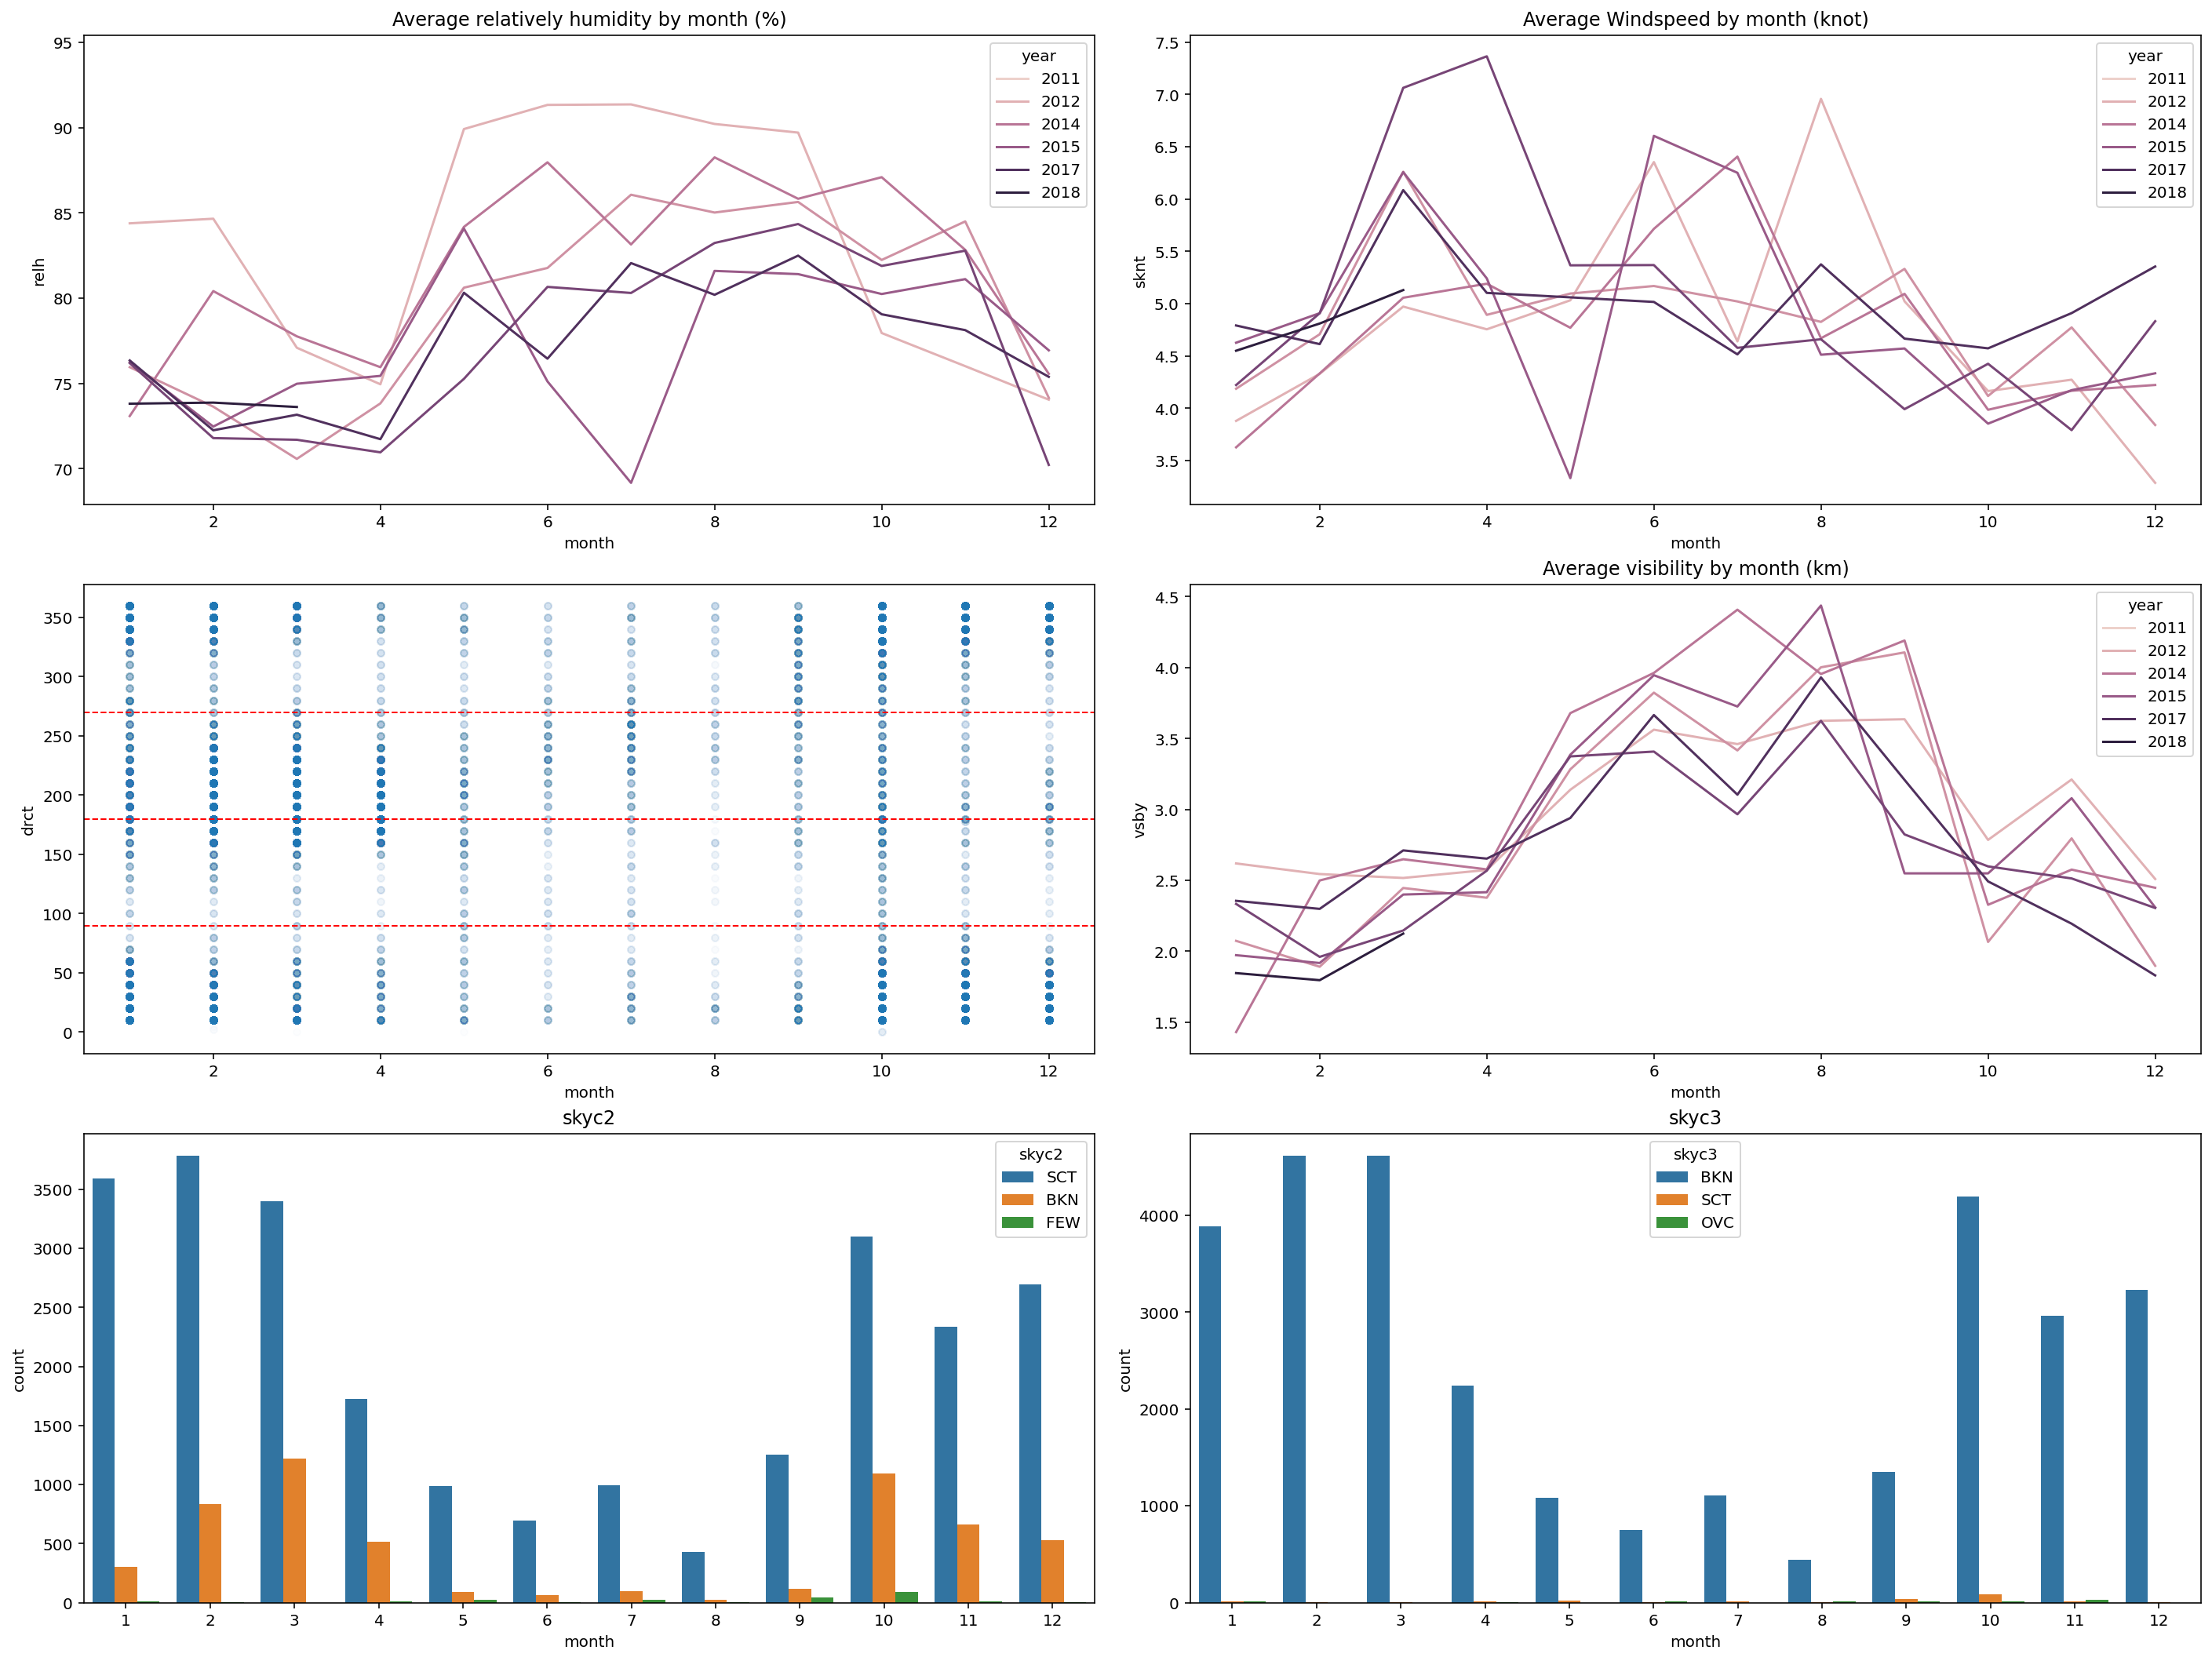

In [40]:
fig, ax = plt.subplots(3,2 , sharex=False, sharey=False, figsize=(20, 15))
fig. tight_layout(pad=3.0)


sns.lineplot(x='month',y='relh',hue="year",ax=ax[0,0] ,data=df1.groupby(['month','year']).mean().reset_index()).set_title('Average relatively humidity by month (%)') 
sns.lineplot(x='month',y='sknt',hue="year",ax=ax[0,1] ,data=df1.groupby(['month','year']).mean().reset_index()).set_title('Average Windspeed by month (knot)')   

graph = df1.plot.scatter(x = 'month', y='drct',ax=ax[1,0] ,alpha = 0.01)
graph.axhline(90,color='r',linestyle='--',linewidth=1)
graph.axhline(180,color='r',linestyle='--',linewidth=1)
graph.axhline(270,color='r',linestyle='--',linewidth=1)

sns.lineplot(x='month',y='vsby',hue="year",ax=ax[1,1] ,data=df1.groupby(['month','year']).mean().reset_index()).set_title('Average visibility by month (km)') 
sns.countplot(x=df1.month,      hue="skyc2",ax=ax[2,0],data=df1).set_title('skyc2');
sns.countplot(x=df1.month,      hue="skyc3",ax=ax[2,1],data=df1).set_title('skyc3');

Text(0.5, 1.0, 'target')

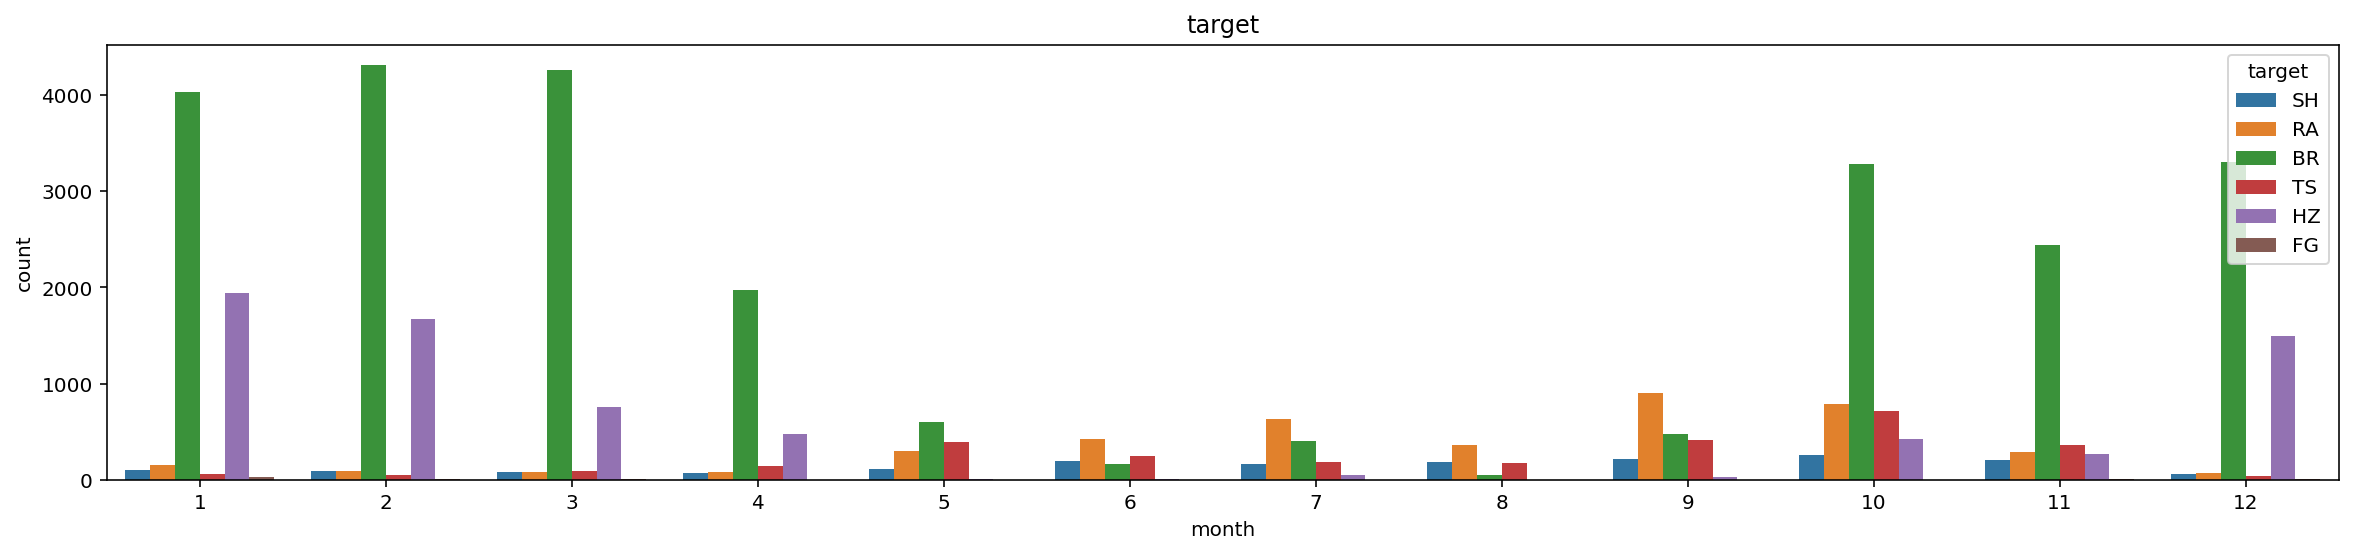

In [41]:
plt.figure(figsize=(20,4))
sns.countplot(x=df.month, hue="target", data=df).set_title('target')

---

    ดังนั้นจากกราฟทั้งหมดบอกได้ว่าจังหวัดระยอง ในช่วงพฤศจิกายน ถึง กุมภาพันธ์ อากาศบริเวณนี้จะค่อนข้างหนาว จากอุณหภูมิที่ต่ำลง ความชื้นในอากาศที่สูงขึ้น , ลมที่พัดมาจากทางทิศตะวันออกเฉียงเหนือ ถึง เหนือ ซึ่งพัดเอาลมหนาวมาจากจีน ทำให้ช่วงนี้เป็นฤดูหนาวของเขตนี้  
  
    ช่วงกุมภา ถึง พฤษภาคม อากาศบริเวณนี้จะค่อนข้างร้อน จากอุณหภูมิที่เพิ่มสูงขึ้นจนถึงเกือบ 30 องศาในบางปี ประกอบกับความชื่นในอากาศที่ลดลง ทำให้เป็นช่วงนี้เป็นช่วงฤดูร้อนของเขตนี้  
  
    ช่วงพฎษภาคม ถึง ตุลาคม อากาศจะร้อนชื้น เป็นผลมาจากอุณหภูมิที่ค่อนข้างร้อน ประกอบกับความชื้นที่เพิ่มสูงขึ้น  
  
    จากกราฟนี้จะเห็นได้ว่าในช่วงเดือน พค ถึง กยเป็นช่วงที่ target class RA มีจำนวนเยอะมากเมื่อเทียบกับ target อื่นๆในช่วงเดียวกัน

---

In [42]:
df1 = df1.drop(columns = ['year','hour'])
df1

,month,tmpc,dwpc,relh,drct,sknt,vsby,skyc2,skyc3,target
0,7,25.0,24.0,94.19,320.0,8.0,4.35,SCT,BKN,SH
1,7,24.0,23.0,94.14,20.0,3.0,3.73,SCT,BKN,RA
3,1,26.0,19.0,65.33,10.0,3.0,3.11,BKN,BKN,BR
5,1,27.0,25.0,88.83,290.0,2.0,4.35,SCT,BKN,SH
6,1,26.0,25.0,94.23,160.0,4.0,3.73,BKN,BKN,SH
...,...,...,...,...,...,...,...,...,...,...
111509,3,26.0,22.0,78.62,340.0,6.0,1.24,SCT,BKN,BR
111510,3,24.0,21.0,83.32,50.0,8.0,1.24,SCT,BKN,BR
111550,3,27.0,22.0,74.11,60.0,4.0,1.86,SCT,BKN,BR
111583,3,24.0,21.0,83.32,350.0,6.0,1.86,SCT,BKN,BR


---

# Model

In [43]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [44]:
# กำหนดตัวแปร X และ Y ในการ train model

outcomename = 'target'
X = df1.drop(columns = outcomename)
Y = df1[outcomename]

### แบ่งข้อมูลเป็น training set และ test set

In [45]:
test_size = 0.2
random_state = 123
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = random_state)

print(f'training set = {X_train.shape[0]:5} records\ntest set     = {X_test.shape[0]:5} records')

training set = 24625 records
test set     =  6157 records


In [46]:
featurename = X.columns
outcome_value = ['1', '2', '3', '4', '5', '6', '7']

In [47]:
# แปลงข้อมูล discrete ให้เป็น continuous

X_train['skyc2'] = X_train['skyc2'].map({'SCT':1, 'BKN':2, 'FEW':3})
X_test['skyc2']  = X_test['skyc2'].map({'SCT':1, 'BKN':2, 'FEW':3})

X_train['skyc3'] = X_train['skyc3'].map({'SCT':1,'BKN':2,'OVC':3})
X_test['skyc3']  = X_test['skyc3'].map({'SCT':1,'BKN':2,'OVC':3})

y_train = y_train.map({'BR':1 ,'HZ':2 ,'RA':3,'TS':4,'SH':5,'VC':6,'FG':7})
y_test  = y_test.map({'BR':1,'HZ':2 ,'RA':3,'TS':4,'SH':5,'VC':6,'FG':7})

# **Decision Tree**

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [49]:
# grid search to config hyparameter
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(1, 100)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [50]:
grid_search_value = dtree_grid_search(X_train,y_train,2)

In [51]:
DTree_Clf = DecisionTreeClassifier(criterion = grid_search_value['criterion'],
                                   max_depth = grid_search_value['max_depth'],
                                   random_state = 0)
DTree_Clf = DTree_Clf.fit(X_train, y_train)

# **Naive Bayes** 

In [52]:
from sklearn.naive_bayes import GaussianNB

In [53]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

# **Bagging**

In [54]:
from sklearn.ensemble import BaggingClassifier

In [55]:
tree1 = DecisionTreeClassifier(criterion=grid_search_value['criterion'],
                               max_depth =grid_search_value['max_depth'],
                               random_state = 0)

bagging_tree = BaggingClassifier(base_estimator=tree1,
                                 n_estimators=500,
                                 max_samples=1.0)

bagging_tree = bagging_tree.fit(X_train, y_train) 

# **Boosting**

In [56]:
from sklearn.ensemble import AdaBoostClassifier

In [57]:
Tree = DecisionTreeClassifier(criterion=grid_search_value['criterion'],
                              max_depth =grid_search_value['max_depth'],
                              random_state = 0)

boosting = AdaBoostClassifier(base_estimator=Tree,
                              n_estimators=50)

boosting = boosting.fit(X_train, y_train)

# **Random Forest**

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestClassifier()

# **XGboost**

In [61]:
import xgboost
from xgboost import XGBClassifier, plot_importance

In [62]:
xgb = XGBClassifier(gamma=0,
                    learning_rate=0.1,
                    max_depth=3,
                    n_estimators=100)
xgb.fit(X_train,y_train)

[00:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Conclusion

In [63]:
# predict test data

DT_y_pred_test = DTree_Clf.predict(X_test)
NB_y_pred_test = gnb.predict(X_test)
bagging_y_pred_test  = bagging_tree.predict(X_test)
boosting_y_pred_test  = boosting.predict(X_test)
rf_y_pred_test =  rf.predict(X_test)
xgb_y_pred_test = xgb.predict(X_test)

model_name = ['Decision_tree', 'Naive bayes', 'Bagging_tree',
              'Boosting_tree', 'Random_forest', 'Xgboost']

pred = [DT_y_pred_test,NB_y_pred_test, bagging_y_pred_test, 
        boosting_y_pred_test, rf_y_pred_test,xgb_y_pred_test]

In [64]:
# Define function accuracy .
Acc = lambda predict : accuracy_score(y_test,predict)*100
B_Acc = lambda pred : balanced_accuracy_score(y_test,pred)*100

# Apply function to each prediction in pred list. (HADOOP concept)
Accuracy = list(map(Acc, pred))
balanced_accuracy = list(map(B_Acc, pred))

# Match model name and Accuracy 
Accuracy = zip(model_name, Accuracy)
balanced_accuracy = zip(model_name, balanced_accuracy)

# Sort by Accuracy 
Accuracy = sorted(Accuracy, key = lambda x: x[1], reverse = True)
balanced_accuracy = sorted(balanced_accuracy, key = lambda x: x[1], reverse = True)

[print('Model: {:20} Accuracy: {:.2f}'.format(*pair)) for pair in Accuracy]
print('-'*80)
[print('Model: {:20} balanced_accuracy: {:.2f}'.format(*pair)) for pair in balanced_accuracy];

Model: Xgboost              Accuracy: 83.12
Model: Bagging_tree         Accuracy: 83.06
Model: Decision_tree        Accuracy: 82.12
Model: Random_forest        Accuracy: 76.27
Model: Naive bayes          Accuracy: 72.00
Model: Boosting_tree        Accuracy: 71.22
--------------------------------------------------------------------------------
Model: Naive bayes          balanced_accuracy: 58.66
Model: Xgboost              balanced_accuracy: 54.73
Model: Bagging_tree         balanced_accuracy: 51.41
Model: Random_forest        balanced_accuracy: 51.12
Model: Decision_tree        balanced_accuracy: 50.99
Model: Boosting_tree        balanced_accuracy: 48.14


    "เนื่องจากtarget class ของ data ที่ใช้เป็นข้อมูลที่ highly imbalanced ดังนั้นเราควรพิจารณาจาก balance accuracy แทนซึ่ง Naive bayes มีค่า balance accuracy สูงที่สุดและเป็นโมเดลที่เราจะนำไปใช้ทำนายสภาพอากาศ"


# Predict future feature

In [65]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [66]:
#ใช้ ipywidget ในการเลือกวันเริ่มต้น และ สิ้นสุดของการ prediction

first = widgets.DatePicker(description='Start date',disabled=False)
last = widgets.DatePicker(description='End date', disabled=False)

In [67]:
#start date
first

DatePicker(value=None, description='Start date')

In [68]:
#end date
last

DatePicker(value=None, description='End date')

In [70]:
# นำข้อมูลวันที่ ที่ได้จากการใส่ข้อมูลวันที่ มาสร้าง dataframe เพื่อ predictหา feature

predict = []
for j in pd.date_range(first.value,last.value,freq = '0.5H'):
    predict.append(j)

test = pd.DataFrame(predict,columns=['valid'])
test['day'] = test['valid'].dt.day
test['month'] = test['valid'].dt.month
test['hour'] = test['valid'].dt.strftime("%H:%M:%S")
test.drop(columns = ['valid'],inplace = True)

In [71]:
# สร้าง function ในการทำ moving average เพื่อหา feature

def predict_feature(month,day,hour,index):
    filter = df[(df['month'] <= month)&(df['day'] <= day)&(df['hour'] <= hour)]
    filter.sort_values(by=['month','day','hour']).tail(10)
    for i in ['tmpc', 'dwpc', 'relh', 'drct', 'sknt', 'alti', 'p01m', 'vsby', 'skyl1', 'skyl2', 'skyl3']:
        value_i = filter[i].rolling(window = 5).mean()
        test.at[index,i] = value_i.iloc[-1]
        for j in['skyc1', 'skyc2', 'skyc3']:
            value_j = filter[j].mode()
            test.at[index,j] = value_j.iloc[-1]
        
    return test

In [72]:
# นำ dataframeวันที่ ที่ได้จากการใส่ข้อมูลมาสร้าง feature ในการ predict ข้อมูล ด้วยวิธีการ moving average 

for i in test.index:
    predict_feature( test.at[i,'month'],test.at[i,'day'],test.at[i,'hour'],i)

    
#แปลงข้อมูล test set ให้อยู่ในรูปเดียวกันกับ train set ที่ใช้ทำการสร้าง

test_data = test.drop(columns = ['day','hour','alti','p01m','skyl1','skyl2','skyl3'])
test_data = test_data[['month','tmpc','dwpc','relh','drct','sknt','vsby','skyc2','skyc3']]
test_data['skyc2'] = test_data['skyc2'].map({'SCT':1, 'BKN':2, 'FEW':3})
test_data['skyc3'] = test_data['skyc3'].map({'SCT':1,'BKN':2,'OVC':3})

In [73]:
# นำ model มา predict ข้อมูล

NB_y_pred_test = gnb.predict(test_data)
test['target'] = NB_y_pred_test

test['target'] = test['target'].map({1:'BR' ,2:'HZ' ,3:'RA',4:'TS',5:'SH',6:'VC',7:'FG'})

In [74]:
test

,day,month,hour,tmpc,skyc1,skyc2,skyc3,dwpc,relh,drct,sknt,alti,p01m,vsby,skyl1,skyl2,skyl3,target
0,24,4,00:00:00,25.8,FEW,SCT,BKN,22.8,83.748,126.0,4.6,29.850,0.0,1.328,1800.0,6815.030916,20067.206656,BR
1,24,4,00:30:00,25.2,FEW,SCT,BKN,22.0,82.654,200.0,6.0,29.828,0.0,1.452,1760.0,3400.000000,17550.404992,BR
2,24,4,01:00:00,24.6,FEW,SCT,BKN,22.0,85.572,80.0,6.8,29.850,0.0,0.842,1720.0,3300.000000,20067.206656,BR
3,24,4,01:30:00,24.6,FEW,SCT,BKN,22.0,85.572,80.0,6.8,29.850,0.0,0.842,1720.0,3300.000000,20067.206656,BR
4,24,4,02:00:00,24.0,FEW,SCT,BKN,21.6,86.490,52.0,6.8,29.854,0.0,0.842,1720.0,3300.000000,22584.008320,BR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,25,4,22:00:00,25.6,FEW,SCT,BKN,21.4,77.816,212.0,5.6,29.808,0.0,1.612,1800.0,4800.000000,17550.404992,BR
93,25,4,22:30:00,25.6,FEW,SCT,BKN,21.4,77.816,212.0,5.6,29.808,0.0,1.612,1800.0,4800.000000,17550.404992,BR
94,25,4,23:00:00,25.6,FEW,SCT,BKN,21.4,77.816,212.0,5.6,29.808,0.0,1.612,1800.0,4800.000000,17550.404992,BR
95,25,4,23:30:00,25.6,FEW,SCT,BKN,21.4,77.816,212.0,5.6,29.808,0.0,1.612,1800.0,4800.000000,17550.404992,BR


In [75]:
# function ในการ filter ผลของการแสดงค่า prediction 

from statistics import *
@interact(Option=['every 30 min','by day'])
def show_value(Option):
    global way
    if Option == 'by day':
        way =  test.groupby(['day','month'])['target'].agg(mode).to_frame().reset_index()
        return way
    else:
        way =  test[['day','month','hour','target']]
        return way


interactive(children=(Dropdown(description='Option', options=('every 30 min', 'by day'), value='every 30 min')…

In [76]:
way.target.value_counts()

BR    3
Name: target, dtype: int64

    โดยในที่นี้สามารถแสดงข้อมูลออกมาได้ 2 รูปแบบคือ 
      1 แสดงค่าพยากรณ์ออกมาทุกๆ 30 นาที ซึ่งประโยชน์ของข้อมูลรูปแบบนี้ก็คือสามารถดูช่วงเวลาในการเดินเรือหรือการขนส่ง 
      2 การดูภาพรวมในทุกๆวัน เพื่อประโยชน์ในการวางแผนงานในอนาคต เช่นการวาง flow งาน การทำ gantt chart ต่างๆ

---
**เราได้เรียนรู้อะไรบ้าง**  
- จากการศึกษาพบว่าในการแก้ค่า hyper parameter ส่งผลให้โมเดลมีประสิทธิภาพในการทำนายที่ต่างกันออกไป ทำให้ในการ config แต่ละค่าควรทำความเข้าใจกับทั้งตัวแปรที่แก้ไข และการทำงานของโมเดล
- Feature ที่ใช้ในการศึกษาบางตัว เช่น ความกดอากาศ ไม่ได้สอดคล้องกับที่กรมอุตตุนิยมวิทยานำไปใช้ คือเมื่อลอง drop feature ตัวนี้กลับพบว่าความแม่นยำของโมเดลเพิ่มขึ้น สวนทางกับที่กรมอุตุนิยมวิทยาได้กล่าวไว้ ทำให้คิดได้ว่าในการพยากรณ์อากาศจริงๆ มีข้อมูลที่มากกว่านี้และละเอียดกว่านี้ในการพิจารณาเช่น ความกดอากาศในระดับความสูงต่างๆ อุณหภูมิในระดับต่างๆ ปัจจัยเหล่านี้ที่เราไม่สามารถรวบรวมมาได้อาจเป็นส่วนที่ทำให้โมเดลไม่ได้มีความแม่นยำมากนัก
  
**ข้อเสนอแนะ**  
- ลองใช้ model ที่หลากหลายมากขึ้นเช่น NN หรือ regression ต่างๆ  
- ศึกษา hyperparameter เพิ่มขึ้น  
- นำ feature ที่กรมอุตตุนิยมวิทยาใช้ในการพิจารณามาพิจารณาเพิ่มเติม เนื่องจากข้อมูล feature ที่มีไม่ได้มีครบทุกปัจจัยที่ควรเป็น    

---
